### Binome :
* Imad Eddine KENAI 191932017671 G3

* Aymen BENKOUITEN  191931046409 G3

# TP 1 Mesures de performance
Dans ce TP, nous aimerions avoir un premier aperçu sur les algorithmes d'apprentissage automatique. Plus précisément, nous aimerions évaluer leurs performances en utilisant les métriques suivantes:
- Matrice de conusion
- Rappel
- Précision
- Taux de FP
- Spécificité
- Courbe ROC

Les mesures devront être calculées sur la tâche de classification de nombres manuscrits.

Le travail consiste à implementer ces métriques et à les comparer avec les métriques des librairies disponibles.

Les algorithmes : K plus Proches Voisins devront être implementés.

# Importation des librairies necessaires au travail

In [43]:
import numpy as np
import cv2 
import pandas as pd
import matplotlib.pyplot as plt
from numpy import random
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

In [44]:
# Pour RNC
from sklearn.model_selection import KFold
from sklearn.cluster import KMeans
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import SGD

# Lecture des fichiers de données à classifier
Pour ce TP, nous allons lire les données à partir d'un fichier csv.

In [45]:
# données
X = np.genfromtxt('data.csv', delimiter=',', dtype=int)
print(X.shape)
df = pd.read_csv("data.csv",nrows=5000)

(5000, 400)


In [46]:
# étiquettes
Y = np.genfromtxt('labels.csv', delimiter=',', dtype=int)
Y[Y==10]=0
Y.shape

(5000,)

Afficher aléatoirement quelques données de notre base

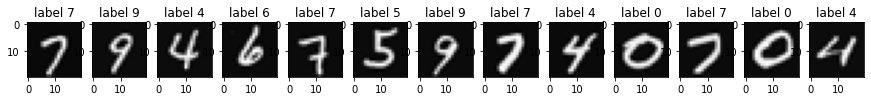

In [47]:
plt.figure(figsize=(15,8))
for i in range(13): #note: each 500 lines, there is a new value
    c = random.randint(X.shape[0]) #pick a random line from the dataset 
    a = X[c,:].reshape((20, 20)) #shape of one number in the image 
    a=np.transpose(a) # la transposé (rendre les ligne des colonne et vice versa)
    plt.subplot(1,13,i+1)
    plt.title('label '+ str(Y[c]))
    plt.imshow(a,cmap='gray')

Notons que l'étiquette 10 concerne le chiffre 0. L'étiquette a été utilisée ainsi afin de faciliter les calculs conséquents.

# Implémentation des métriques demandées
Ici il faut écrire les fonctions, puis les appeler dans la suite du code

- Matrice de confusion :

In [48]:
# en entrée on a les labels ground truth y_test et les labels prédit y_pred
def ConfusionMatrix(y_test, y_pred):
    # on creer une matrice de  zéro  n*n  ou n est le nombre de classe 
    N = len(np.unique(y_test)) 
    M = np.zeros((N,N),dtype="int64")  
     # on doit caster le vecteur des prédiction car certain modèle retourne les classes comme des réels
    y_pred=y_pred.astype(int)
    # on parcoure les deux vecteurs en meme temps et en met ajour la matrice de confusion 
    for i in range(len(y_test)): 
        M[y_test[i],y_pred[i]] = M[y_test[i],y_pred[i]] +1 
    return M

In [49]:
# on prend la matrice de confusion et on extrait les vrai positifs,les faux négatifs,les faux positifs et les vrai négatifs
#pour chaque classe
def extract(m):
    TP=m.diagonal() # les vrai positifs c'est la diagonale
    FN=np.sum(m,axis=1)-TP # les faux négatifs sont la somme des lignes moin les vrai positifs
    FP=np.sum(m,axis=0)-TP # les faux positifs sont la somme des colonnes moin les vrai positifs
    TN= np.full(m.shape[0], np.sum(m))-(TP+FN+FP) # les vrai positifs c'est la somme de la matrice moins les autres métriques

    return TP,FN,FP,TN

- Accuracy = (TP + TN)/(TP + TN + FP + FN)

In [50]:
def Accuracy(TP,TN,FP,FN):
    Accuracy=(TP+TN)/( TP+TN + FP + FN)
    return Accuracy


- Recall (True Positive Rate) = TP/(TP + FN)

In [51]:
def Recall(TP,FN):
    Recall=TP /(TP  + FN)
    return Recall


- Précision = TP/(TP + FP)

In [52]:
def Precision(TP,FP):
    Precision=TP/(TP  + FP)
    return Precision


- Taux de FP (False Positive Rate) = FP / (FP + TN)

In [53]:
def Taux_FP(FP,TN):
    Taux_FP= FP /(FP  + TN)
    return Taux_FP

- Spécificité (True Negative Rate) = TN / (TN + FP)

In [54]:
def Specificite(TN,FP):
    Specificite=TN /(TN  + FP)
    return Specificite


- Courbe ROC

In [55]:
# pour creer la  courbe roc  d'une classe en plus des labels et des prédiction on précise la classe c et aussi les seuils 
# par la suite on opte pour l'utilisation des seuils géneré par sklearn pour avoir une meilleurs courbe 
def Courbe_ROC(y_test, y_pred,c,ths):
    #liste des Taux de faux positif et vrai positif 
    fpr=[]
    tpr=[]
    # o selection d'un vecteur de proba de la classe c
    
    pred=y_pred[:,c]
    
    #conversion en binaire
    test=np.copy(y_test)
    
    test[test==c]=22
    test[test<22]=0
    test[test==22]=1
    
   # pour chaque valeur du seuil on teste si superieur alors 1 sinon 0
    for th in ths:
        # selon le seuil on met les proba du vecteur de prédiction a 1 ou 0
        predth=np.copy(pred)
        predth[predth<th]=0
        predth[predth>=th]=1
        #on utilisant les fonctions déja définit ont calcule  Taux de faux positif et vrai positif  en on rajoute a 
        #leurs liste resprctive les valeur pour la classe 1 
        m=ConfusionMatrix(test, predth)
        TP,FN,FP,TN=extract(m)
        fpr.append(Taux_FP(FP,TN)[1])
        tpr.append(Recall(TP,FN)[1])
    return fpr,tpr

In [56]:
#calcule les valeurs pour tracer les courbe roc pour toute les classe une fois avec fonction sklearn et aprés 
# avec nos propre méthode 
def roc_class(y_test,y_pred):
    fprs=[]
    tprs=[]
    rocs=[]
    fprs1=[]
    tprs1=[]
    rocs1=[]  
    for c in range (0,10): 
        #pour chaque classe calcule de  Taux de faux positif et vrai positif  on utilisant sklearn
        Yttt=np.copy(y_test)
        Yttt[Yttt==c]=10
        Yttt[Yttt<10]=0
        Yttt[Yttt==10]=1
        pp=y_pred[:,c]
        fpr,tpr,th=metrics.roc_curve(Yttt,pp)
        auc = metrics.auc(fpr, tpr)  # calcule du AUC
        print(th)
        fprs.append(fpr)
        tprs.append(tpr)
        rocs.append(auc)
        #  calcule de  Taux de faux positif et vrai positif  on utilisant notre implémentation
        fpr1,tpr1=Courbe_ROC(y_test, y_pred,c,th)
        auc1=np.trapz(tpr1,fpr1) # calcule du auc en utilisant l'integral avec la fonction trapz 
        fprs1.append(fpr1)
        tprs1.append(tpr1)
        rocs1.append(auc1)
        
    return  fprs,tprs,rocs,fprs1,tprs1,rocs1  

In [57]:
#tracer les courbe de chaque classe dans le meme graphe 
def roc_figure(fprs,tprs,rocs) :
    plt.figure()
    lw = 2 # précisé l'épesseur des graphes 
    for i in range (0,10): 
        #tracer la courbe de la classe i et afficher la valeur du AUC dans le label
        plt.plot(fprs[i], tprs[i],lw=lw, label='Class'+str(i)+' ROC curve (AUC = %0.2f)' % rocs[i])
    #droite pour comparez avec 
    plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
    #légerment espacé les axes des x et y pour que les graphes ne soit pas collé aux axes 
    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curves')
    plt.legend(loc="lower right")
    plt.show()
 

# Classification

Définir d'abord la base d'entrainement Xt, Yt et la base de test Xtt, Ytt

In [58]:
scaler = StandardScaler()
scaler.fit(X)
scaled_features = scaler.transform(X)
Xt, Xtt, Yt, Ytt = train_test_split(
      scaled_features, Y, test_size = 0.30)


# Méthode 0: K- Plus Proches Voisins

Ici il faudra implémenter la méthode, puis la tester et vérifier les métriques en variant le nombre K

In [59]:
# on definit le modèle knn comme une classe 
class KNNClassifier:
    #dans le constructeure de la classe on précise la valeur de K
    def __init__(self, k):
        self.k = k
    # lors du fit on vas sauvgardé le données et labels du training set pour les utilisé lors du calcule des distances 
    # pour faire les prédictions     
    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
   #la methode predict retoun les prédiction pour un vecteur en entrée      
    def predict(self, X):
        predictions = []
        for x in X:
            # pour chaque données du vecteurs X en calcule les prédictions
            # on calcule la distances euclidean en exploitant np.sum pour faire un calcule pour chaque ligene du trainset 
            #et eviter l'utilisation d'une boucle
            distances = np.sqrt(np.sum((self.X_train - x)**2, axis=1))
            # on trie la liste des distance avec argsort qui retourne les index trié et on selectionne les k plus proche voisin
            nearest_neighbors = np.argsort(distances)[:self.k]
            # on récupére les labels des k plus proches voisin 
            nearest_labels = self.y_train[nearest_neighbors]
            #on calcule la fréquences des classes dans les k-plus proche voisin et la classe prédite
            #est la classe avec la plus grande fréquences
            counts = np.bincount(nearest_labels)
            predicted_label = np.argmax(counts)
            predictions.append(predicted_label)
        return np.array(predictions)
    #pour le calcule des proba on procéde de la meme manière 
    def predict_proba(self, X):
       
        probas = []
        for x in X:
            distances = np.sqrt(np.sum((self.X_train - x)**2, axis=1))
            nearest_neighbors = np.argsort(distances)[:self.k]
            nearest_labels = self.y_train[nearest_neighbors]
            # mais lors du calcule des fréquences on vas forcé la methode de consideré toutes les classes pas 
            # seulement les classe présent parmis les k plus proche voisin
            counts = np.bincount(nearest_labels, minlength=len(np.unique(self.y_train)))
            # on dévise les fréquence par k pour optenir le vecteur de proba 
            proba = counts / self.k
            probas.append(proba)
        
        return np.array(probas)



In [60]:
#example d'utilisation du knn de sklearn

knn = KNeighborsClassifier(n_neighbors = 8).fit(Xt, Yt)
  
y_pred = knn.predict(Xtt)
recall=metrics.recall_score(Ytt, y_pred,average="macro")
print( recall)

0.8518840286016365


In [61]:
#example d'utilisation de notre implémentation de knn

knn = KNNClassifier(k=8)
knn.fit(Xt, Yt)
y_pred = knn.predict(Xtt)
m= ConfusionMatrix(Ytt, y_pred)
TP,FN,FP,TN=extract(m)
b= Recall(TP,FN)
print(np.mean(b))

0.8518840286016365


# Méthode 1: MVS
Machine à Vecteurs de Support

In [62]:
#Créer le modèle
model= svm.SVC(kernel='linear') 
# entrainement 
model.fit(Xt, Yt)
# Prediction
y_pred = model.predict(Xtt)

6


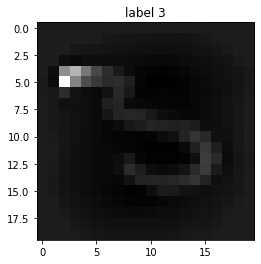

In [63]:
# tester une image
c= 3
print (y_pred[c])
a = Xtt[c,:].reshape((20, 20))
a=np.transpose(a)
plt.title('label '+ str(Ytt[c]))
plt.imshow(a,cmap='gray')

# Méthode 2: Arbres de décision


In [64]:
# Créer le modèle
model = DecisionTreeClassifier()
# Entrainer le modèle
model = model.fit(Xt, Yt)
# Prediction
y_pred = model.predict(Xtt)

3


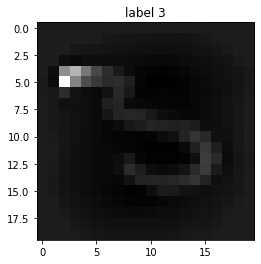

In [65]:
# tester une image
c= 3
print (y_pred[c])
a = Xtt[c,:].reshape((20, 20))
a=np.transpose(a)
plt.title('label '+ str(Ytt[c]))
plt.imshow(a,cmap='gray')

# Méthode 3: RN 
Réseaux de neurones Perceptron

In [66]:
model = MLPClassifier(solver='sgd', alpha=1e-5, hidden_layer_sizes=(25),max_iter=100000)
#Xt, Xtt, Yt, Ytt = train_test_split(X, Y, random_state=0, test_size=0.7)
model.fit(Xt, Yt)


MLPClassifier(alpha=1e-05, hidden_layer_sizes=25, max_iter=100000, solver='sgd')

In [67]:
# Choisir un image de test 
c=0

In [68]:
model.predict([Xtt[c,:]])

array([6])

In [69]:
# pour ROC, il faudra les probabilités:
model.predict_proba([Xtt[c,:]])

array([[9.44472680e-10, 6.29876969e-13, 1.46303133e-05, 4.84691791e-11,
        7.37984601e-06, 1.79822198e-08, 9.99977963e-01, 2.02321043e-09,
        6.31539544e-09, 3.70591941e-12]])

Afficher l'image testée

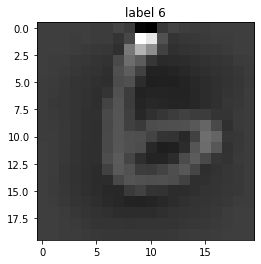

In [70]:
a = Xtt[c,:].reshape((20, 20))
a=np.transpose(a)
plt.title('label '+ str(Ytt[c]))
plt.imshow(a,cmap='gray')

# Méthode 4: RNC
Réseaux de Neurones Convolutifs

# Appliquer les métriques implementées pour voir le résultat

### Dans cette partie on vas comparé l'implementation des métriques de sklearn avec notre implémentation  :
* sklearn a comme métrique définit la matrice de confusion , l'accuracy ,le recall (rapell) et la precision (c'est métrique seront calculé pour tous les modèle knn,svm,arbre de décision et résaux de nouerone ).
* sklearn ne permmet pas de claculé directement ne premet pas de calculer la Spécificité et le Taux de FP directement dans le cadre de classification multi-class  mais il permet de les calculer dans un cas binaire dans le cadre de la courbe ROC donc on vas tracer les courbe ROC pour toutes les classes en utilsant notre implémentation et l'implémentation de sklearn (pour les modèle qui retoune aussi des proba dans notre cas knn et RN).
* lors des évaluation on a trouvez que l'implementation de sklearn de l'accuracy  est différente de l'implémentation qu'on a vu durant le cour et le tp sklearn calcule l'accuracy de la maniére suivante (nombre d'instance bien prédit)/(nombre totale des instances) donc on a implémenter une autre fonction pour calculer de l'accuracy de la meme maniére et on vas afficher l'accuracy selon les deux définition 
* pour la précision et le recall la valeur retourner par sklearn pour le multi class la valeur retourner est la moyenne de la métrique pour chaque classe donc lors de l'affichage en vas afficher la moyenne du vecteur retourner par notre implémentation 

In [71]:
#implémentation de l'accuracy comme définit par sklearn ou TP est le vecteur des vrai postifs pour chaque classe 
# et N et le nombre de données prédites
def accuracy_sk(TP,N):
    accuracy=np.sum(TP)/N
    return accuracy

## KNN

### Calcul des métriques 

In [72]:
#géneration des prediction avec knn de sklearn et calcule des métrique en utilsant sklearn

knn = KNeighborsClassifier(n_neighbors = 8).fit(Xt, Yt)
y_pred = knn.predict(Xtt)

m=metrics.confusion_matrix(Ytt, y_pred)
accuracy=metrics.accuracy_score(Ytt, y_pred)
recall=metrics.recall_score(Ytt, y_pred,average='macro')
precision=metrics.precision_score(Ytt, y_pred,average='macro')

In [73]:
#géneration des prediction avec notre implémentation  de knn et calcule des métrique en utilsant notre implémentation

knntp = KNNClassifier(k=8)
knntp.fit(Xt, Yt)
y_pred = knntp.predict(Xtt)
print(y_pred.shape)
mtp= ConfusionMatrix(Ytt, y_pred)
TP,FN,FP,TN=extract(mtp)
accuracytp=np.mean(Accuracy(TP,TN,FP,FN))
accuracytp_sk=accuracy_sk(TP,len(Xtt))
recalltp= np.mean(Recall(TP,FN))
precisiontp= np.mean(Precision(TP,FP))

(1500,)


In [74]:
# affichage des résultats
print("matrice de confusion sklearn \n")
print(m)
print("\n matrice de confusion implémentation TP \n")
print(mtp)
print("\n accuracy sklearn: "+str(accuracy))
print("\n accuracy implementé comme sklearn: "+str(accuracytp_sk))
print("\n accuracy implementé selon la définition du cour: "+str(accuracytp))
print("\n recall sklearn: "+str(recall))
print("\n recall implémentation TP: "+str(recalltp))
print("\n précision sklearn: "+str(precision))
print("\n précision implémentation TP: "+str(precisiontp))


matrice de confusion sklearn 

[[134   0   1   0   0   0   4   0   0   0]
 [  0 153   0   1   0   0   0   0   0   0]
 [  3   9 127   6   5   1   1   0   9   0]
 [  0   3   3 128   2   1   0   1   2   4]
 [  1   5   2   1 131   4   1   1   0  19]
 [  3   3   1   8   3 105   2   0   5   4]
 [  5   1   1   0   5   3 149   0   0   0]
 [  0  12   1   1   5   1   0 107   0  15]
 [  1   5   1   3   2   7   0   0 124   3]
 [  0   2   4   3  10   1   0  10   1 120]]

 matrice de confusion implémentation TP 

[[134   0   1   0   0   0   4   0   0   0]
 [  0 153   0   1   0   0   0   0   0   0]
 [  3   9 127   6   5   1   1   0   9   0]
 [  0   3   3 128   2   1   0   1   2   4]
 [  1   5   2   1 131   4   1   1   0  19]
 [  3   3   1   8   3 105   2   0   5   4]
 [  5   1   1   0   5   3 149   0   0   0]
 [  0  12   1   1   5   1   0 107   0  15]
 [  1   5   1   3   2   7   0   0 124   3]
 [  0   2   4   3  10   1   0  10   1 120]]

 accuracy sklearn: 0.852

 accuracy implementé comme sklearn: 0

### Courbe ROC

In [75]:
print(Xtt.shape)
pred=knntp.predict_proba(Xtt)
print(pred.shape)


(1500, 400)
(1500, 10)


(1500, 10)
[2.    1.    0.875 0.75  0.625 0.5   0.375 0.25  0.125 0.   ]
[2.    1.    0.875 0.75  0.625 0.5   0.375 0.25  0.125 0.   ]
[2.    1.    0.875 0.75  0.625 0.5   0.375 0.25  0.125 0.   ]
[2.    1.    0.875 0.75  0.625 0.5   0.375 0.25  0.125 0.   ]
[2.    1.    0.875 0.75  0.625 0.5   0.375 0.25  0.125 0.   ]
[2.    1.    0.875 0.75  0.625 0.5   0.375 0.25  0.125 0.   ]
[2.    1.    0.875 0.75  0.625 0.5   0.375 0.25  0.125 0.   ]
[2.    1.    0.875 0.75  0.625 0.5   0.375 0.25  0.125 0.   ]
[2.    1.    0.875 0.75  0.625 0.5   0.375 0.25  0.125 0.   ]
[2.    1.    0.875 0.75  0.625 0.5   0.375 0.25  0.125 0.   ]
Courbe ROC avec sklearn


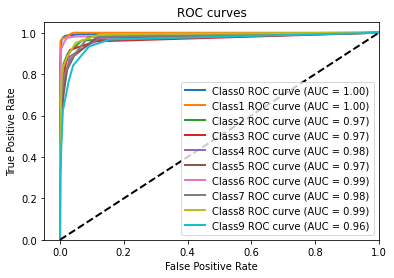

Courbe ROC avec notre implémentation
(1500, 10)
[2.    1.    0.875 0.75  0.625 0.5   0.375 0.25  0.125 0.   ]
[2.    1.    0.875 0.75  0.625 0.5   0.375 0.25  0.125 0.   ]
[2.    1.    0.875 0.75  0.625 0.5   0.375 0.25  0.125 0.   ]
[2.    1.    0.875 0.75  0.625 0.5   0.375 0.25  0.125 0.   ]
[2.    1.    0.875 0.75  0.625 0.5   0.375 0.25  0.125 0.   ]
[2.    1.    0.875 0.75  0.625 0.5   0.375 0.25  0.125 0.   ]
[2.    1.    0.875 0.75  0.625 0.5   0.375 0.25  0.125 0.   ]
[2.    1.    0.875 0.75  0.625 0.5   0.375 0.25  0.125 0.   ]
[2.    1.    0.875 0.75  0.625 0.5   0.375 0.25  0.125 0.   ]
[2.    1.    0.875 0.75  0.625 0.5   0.375 0.25  0.125 0.   ]


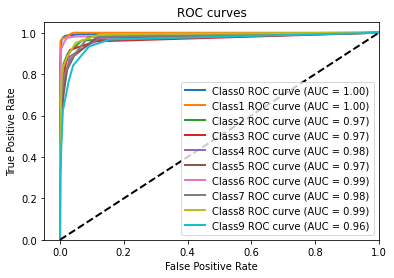

In [76]:
#géneration des probas et creation des courbe ROC avec sklearn 

pred=knn.predict_proba(Xtt)
print(pred.shape)
fprs,tprs,rocs,_,_,_ =roc_class(Ytt,pred)
print("Courbe ROC avec sklearn")
roc_figure(fprs,tprs,rocs) 
print("Courbe ROC avec notre implémentation")
#géneration des probas et creation des courbe ROC avec notre implémentation

pred=knntp.predict_proba(Xtt)
print(pred.shape)
_,_,_,fprs1,tprs1,rocs1 =roc_class(Ytt,pred)
roc_figure(fprs1,tprs1,rocs1 )

## SVM

### Calcul des métriques 

In [77]:
#géneration des prediction  

model= svm.SVC(kernel='linear')  
model.fit(Xt, Yt)
y_pred = model.predict(Xtt)

# calcule des métrique en utilsant sklearn

m=metrics.confusion_matrix(Ytt, y_pred)
accuracy=metrics.accuracy_score(Ytt, y_pred)
recall=metrics.recall_score(Ytt, y_pred,average='macro')
precision=metrics.precision_score(Ytt, y_pred,average='macro')

# calcule des métrique en utilsant notre implémentation

mtp= ConfusionMatrix(Ytt, y_pred)
TP,FN,FP,TN=extract(mtp)
accuracytp=np.mean(Accuracy(TP,TN,FP,FN))
accuracytp_sk=accuracy_sk(TP,len(Xtt))
recalltp= np.mean(Recall(TP,FN))
precisiontp= np.mean(Precision(TP,FP))

# affichage des résultats

print("matrice de confusion sklearn \n")
print(m)
print("\n matrice de confusion implémentation TP \n")
print(mtp)
print("\n accuracy sklearn: "+str(accuracy))
print("\n accuracy implementé comme sklearn: "+str(accuracytp_sk))
print("\n accuracy implementé selon la définition du cour: "+str(accuracytp))
print("\n recall sklearn: "+str(recall))
print("\n recall implémentation TP: "+str(recalltp))
print("\n précision sklearn: "+str(precision))
print("\n précision implémentation TP: "+str(precisiontp))

matrice de confusion sklearn 

[[136   0   1   0   0   2   0   0   0   0]
 [  0 151   0   0   0   0   0   2   1   0]
 [  3   6 139   3   3   0   2   1   4   0]
 [  0   1   3 123   1   8   1   1   3   3]
 [  3   0   2   0 151   1   2   3   0   3]
 [  1   6   1   4   0 120   1   0   0   1]
 [  2   0   2   0   0   3 156   0   1   0]
 [  0   0   3   0   2   1   0 130   1   5]
 [  0   1   1   3   1   7   3   1 129   0]
 [  1   0   4   3  15   2   0   7   2 117]]

 matrice de confusion implémentation TP 

[[136   0   1   0   0   2   0   0   0   0]
 [  0 151   0   0   0   0   0   2   1   0]
 [  3   6 139   3   3   0   2   1   4   0]
 [  0   1   3 123   1   8   1   1   3   3]
 [  3   0   2   0 151   1   2   3   0   3]
 [  1   6   1   4   0 120   1   0   0   1]
 [  2   0   2   0   0   3 156   0   1   0]
 [  0   0   3   0   2   1   0 130   1   5]
 [  0   1   1   3   1   7   3   1 129   0]
 [  1   0   4   3  15   2   0   7   2 117]]

 accuracy sklearn: 0.9013333333333333

 accuracy implementé com

## Arbres de décision 

### Calcul des métriques 

In [78]:
#géneration des prediction 

model = DecisionTreeClassifier()
model = model.fit(Xt, Yt)
y_pred = model.predict(Xtt)

# calcule des métrique en utilsant sklearn

m=metrics.confusion_matrix(Ytt, y_pred)
accuracy=metrics.accuracy_score(Ytt, y_pred)
recall=metrics.recall_score(Ytt, y_pred,average='macro')
precision=metrics.precision_score(Ytt, y_pred,average='macro')

# calcule des métrique en utilsant notre implémentation

mtp= ConfusionMatrix(Ytt, y_pred)
TP,FN,FP,TN=extract(mtp)
accuracytp=np.mean(Accuracy(TP,TN,FP,FN))
accuracytp_sk=accuracy_sk(TP,len(Xtt))
recalltp= np.mean(Recall(TP,FN))
precisiontp= np.mean(Precision(TP,FP))

# affichage des résultats

print("matrice de confusion sklearn \n")
print(m)
print("\n matrice de confusion implémentation TP \n")
print(mtp)
print("\n accuracy sklearn: "+str(accuracy))
print("\n accuracy implementé comme sklearn: "+str(accuracytp_sk))
print("\n accuracy implementé selon la définition du cour: "+str(accuracytp))
print("\n recall sklearn: "+str(recall))
print("\n recall implémentation TP: "+str(recalltp))
print("\n précision sklearn: "+str(precision))
print("\n précision implémentation TP: "+str(precisiontp))

matrice de confusion sklearn 

[[122   0   1   4   0   5   1   1   3   2]
 [  0 133   4   2   1   3   2   1   8   0]
 [  1   5 104  19   3   5   5   3  14   2]
 [  6   4   9  89   6  10   1   7   9   3]
 [  1   0   1   1 131   4   5   5   6  11]
 [  7   4   6  11   1  90   7   1   5   2]
 [  5   0   4   1   5   7 135   0   5   2]
 [  1   1   1   3   2   0   0 118   6  10]
 [  3   1  17   8   2   8   1   2  98   6]
 [  2   3   7   5   8   1   2  13   8 102]]

 matrice de confusion implémentation TP 

[[122   0   1   4   0   5   1   1   3   2]
 [  0 133   4   2   1   3   2   1   8   0]
 [  1   5 104  19   3   5   5   3  14   2]
 [  6   4   9  89   6  10   1   7   9   3]
 [  1   0   1   1 131   4   5   5   6  11]
 [  7   4   6  11   1  90   7   1   5   2]
 [  5   0   4   1   5   7 135   0   5   2]
 [  1   1   1   3   2   0   0 118   6  10]
 [  3   1  17   8   2   8   1   2  98   6]
 [  2   3   7   5   8   1   2  13   8 102]]

 accuracy sklearn: 0.748

 accuracy implementé comme sklearn: 0

## RN

### Calcul des métriques 

In [79]:
#géneration des prediction 

model = MLPClassifier(solver='sgd', alpha=1e-5, hidden_layer_sizes=(25),max_iter=100000)
model.fit(Xt, Yt)
y_pred=model.predict(Xtt)

# calcule des métrique en utilsant sklearn

m=metrics.confusion_matrix(Ytt, y_pred)
accuracy=metrics.accuracy_score(Ytt, y_pred)
recall=metrics.recall_score(Ytt, y_pred,average='macro')
precision=metrics.precision_score(Ytt, y_pred,average='macro')

# calcule des métrique en utilsant notre implémentation

mtp= ConfusionMatrix(Ytt, y_pred)
TP,FN,FP,TN=extract(mtp)
accuracytp=np.mean(Accuracy(TP,TN,FP,FN))
accuracytp_sk=accuracy_sk(TP,len(Xtt))
recalltp= np.mean(Recall(TP,FN))
precisiontp= np.mean(Precision(TP,FP))

# affichage des résultats

print("matrice de confusion sklearn \n")
print(m)
print("\n matrice de confusion implémentation TP \n")
print(mtp)
print("\n accuracy sklearn: "+str(accuracy))
print("\n accuracy implementé comme sklearn: "+str(accuracytp_sk))
print("\n accuracy implementé selon la définition du cour: "+str(accuracytp))
print("\n recall sklearn: "+str(recall))
print("\n recall implémentation TP: "+str(recalltp))
print("\n précision sklearn: "+str(precision))
print("\n précision implémentation TP: "+str(precisiontp))

    

matrice de confusion sklearn 

[[137   0   0   1   0   1   0   0   0   0]
 [  0 151   0   0   0   1   0   0   1   1]
 [  4   2 137   5   1   2   3   0   7   0]
 [  0   0   3 128   1   7   1   1   1   2]
 [  2   0   1   2 145   1   4   1   1   8]
 [  2   3   0   4   0 120   2   1   1   1]
 [  3   0   0   0   1   2 157   0   1   0]
 [  0   1   1   1   0   0   1 132   1   5]
 [  0   1   2   3   2   4   3   1 128   2]
 [  0   1   3   3   5   1   1   5   1 131]]

 matrice de confusion implémentation TP 

[[137   0   0   1   0   1   0   0   0   0]
 [  0 151   0   0   0   1   0   0   1   1]
 [  4   2 137   5   1   2   3   0   7   0]
 [  0   0   3 128   1   7   1   1   1   2]
 [  2   0   1   2 145   1   4   1   1   8]
 [  2   3   0   4   0 120   2   1   1   1]
 [  3   0   0   0   1   2 157   0   1   0]
 [  0   1   1   1   0   0   1 132   1   5]
 [  0   1   2   3   2   4   3   1 128   2]
 [  0   1   3   3   5   1   1   5   1 131]]

 accuracy sklearn: 0.9106666666666666

 accuracy implementé com

### Courbe ROC

Courbe ROC avec sklearn
[1.99999958e+00 9.99999583e-01 9.92307467e-01 9.91450172e-01
 9.83354679e-01 9.83195317e-01 8.91159167e-01 7.21528873e-01
 6.63520821e-01 4.34740963e-01 3.54662777e-01 1.45997769e-01
 1.26060236e-01 5.58335570e-02 5.51597768e-02 2.91722504e-17]
[1.99963155e+00 9.99631549e-01 9.50265914e-01 9.48901789e-01
 8.39759325e-01 8.30755460e-01 6.15435323e-01 5.96430272e-01
 5.52393525e-01 4.78051705e-01 3.71719483e-01 3.59173306e-01
 2.99156075e-01 1.79816495e-01 1.50292661e-01 6.40180944e-02
 6.03523896e-02 2.02325330e-03 1.99504758e-03 3.72427446e-16]
[1.99999977e+00 9.99999771e-01 9.98800345e-01 9.98702633e-01
 9.97270206e-01 9.97251791e-01 9.57795368e-01 9.48965241e-01
 9.31326127e-01 9.29356657e-01 8.33482202e-01 8.29426439e-01
 6.94833764e-01 6.89808327e-01 6.08868315e-01 6.01191550e-01
 5.99164773e-01 5.78971434e-01 5.57385332e-01 4.69531118e-01
 3.92646943e-01 3.58137320e-01 3.31595913e-01 1.98803217e-01
 1.85569102e-01 1.80112626e-01 1.79520406e-01 1.61722107e-0

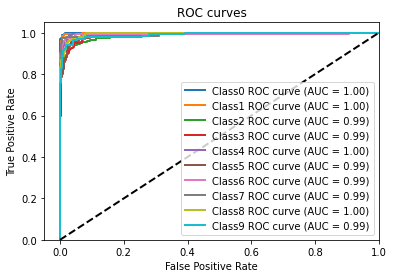

Courbe ROC avec notre implémentation


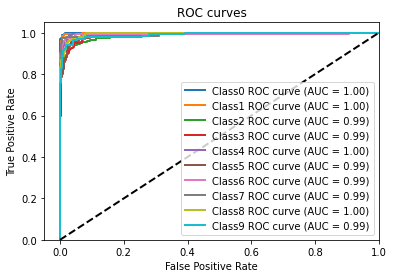

In [39]:
#géneration des probas
pred=model.predict_proba(Xtt)
print("Courbe ROC avec sklearn")
fprs,tprs,rocs,fprs1,tprs1,rocs1 =roc_class(Ytt,pred)
roc_figure(fprs,tprs,rocs) 
print("Courbe ROC avec notre implémentation")
roc_figure(fprs1,tprs1,rocs1) 